In [24]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [25]:
#  Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import warnings
warnings.filterwarnings("ignore") 

In [26]:
# User settings 
TICKER = "AAPL"                    
START_DATE = "2025-01-01"          
END_DATE = pd.Timestamp.today().strftime("%Y-%m-%d")  # uses today's date
SEQ_LENGTH = 60                    
TEST_RATIO = 0.2                   
BATCH_SIZE = 32
EPOCHS = 30
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Ticker={TICKER}, date range={START_DATE} to {END_DATE}")


Ticker=AAPL, date range=2025-01-01 to 2025-11-08


In [27]:
# Download historical data
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
print("Downloaded rows:", len(df))
df.tail()


Downloaded rows: 214


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-11-03,269.049988,270.850006,266.250000,270.420013,50194600
2025-11-04,270.040009,271.489990,267.619995,268.329987,49274800
2025-11-05,270.140015,271.700012,266.929993,268.609985,43683100
2025-11-06,269.769989,273.399994,267.890015,267.890015,51204000
2025-11-07,268.470001,272.290009,266.769989,269.799988,48203600


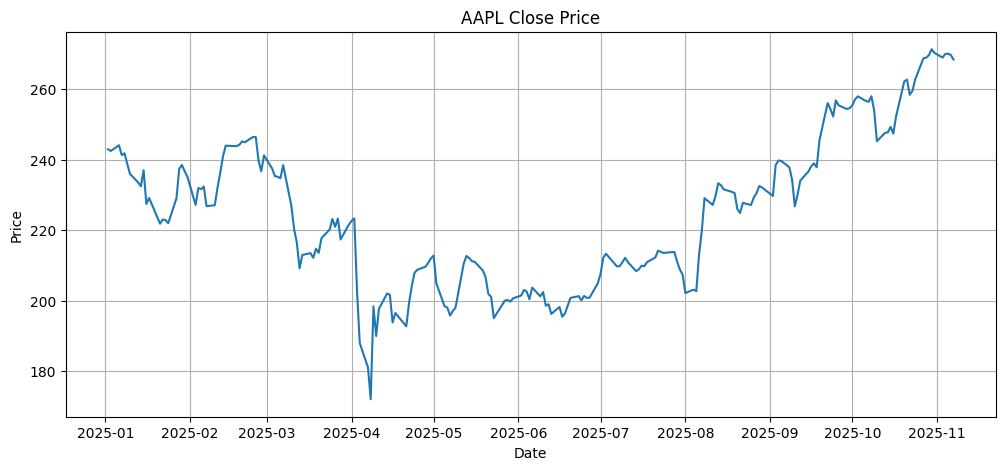

In [28]:
# Inspect & visualize close price
df = df.dropna()
plt.figure(figsize=(12,5))
plt.plot(df['Close'])
plt.title(f"{TICKER} Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


In [29]:
prices = df[['Close']].values.astype('float32')

# Scale prices to [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
prices_scaled = scaler.fit_transform(prices)


In [30]:
# Create sequences (fixed function)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = create_sequences(prices_scaled, SEQ_LENGTH)
print("Sequences created:", X.shape, y.shape)


Sequences created: (154, 60, 1) (154, 1)


In [31]:
# Train/test split
train_size = int(len(X) * (1 - TEST_RATIO))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape :", X_test.shape, y_test.shape)


Train shape: (123, 60, 1) (123, 1)
Test shape : (31, 60, 1) (31, 1)


In [32]:
# Model definition
def build_model(seq_length):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_model(SEQ_LENGTH)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Callbacks and training
checkpoint_path = os.path.join(MODEL_DIR, f"{TICKER}_best.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.1884
Epoch 1: val_loss improved from None to 0.34932, saving model to models\AAPL_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - loss: 0.1625 - val_loss: 0.3493
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0604
Epoch 2: val_loss improved from 0.34932 to 0.00708, saving model to models\AAPL_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0424 - val_loss: 0.0071
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0252
Epoch 3: val_loss improved from 0.00708 to 0.00402, saving model to models\AAPL_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0328 - val_loss: 0.0040
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0214
Epoch 4: val_loss did not improve from 0.00402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0183 - val_loss: 0.0780
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0224
Epoch 5: val_loss did not improve from 0.00402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.0237 - val_loss: 0.1020
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0203
Epoch 6: val_loss did not improve from 0.00402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0180 - val_loss: 0.0522
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0188
Epoch 7: val_loss did not improve from 0.00402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.0148 - val_loss: 0.0171
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0181
Epoch 8: val_loss did not improve from 0.00402
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.0152 - val_loss: 0.0137
Epo

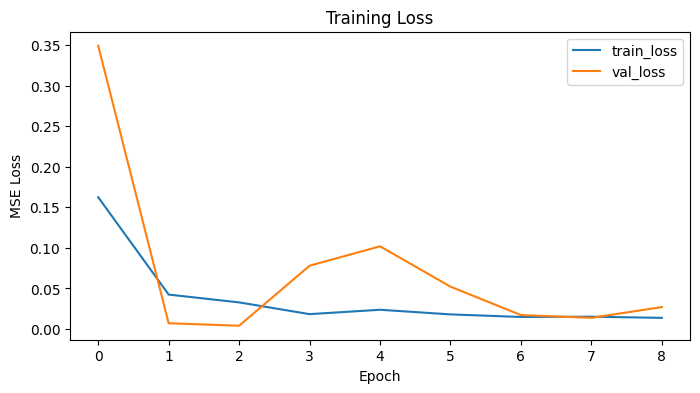

In [34]:
# Training plots 
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [35]:
# Make predictions on test set and inverse transform
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)        # predicted prices
y_test_unscaled = scaler.inverse_transform(y_test)  # true prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


In [36]:
# Evaluation metrics
mse = mean_squared_error(y_test_unscaled, pred)
mae = mean_absolute_error(y_test_unscaled, pred)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 39.7376
RMSE: 6.3038
MAE: 5.0025


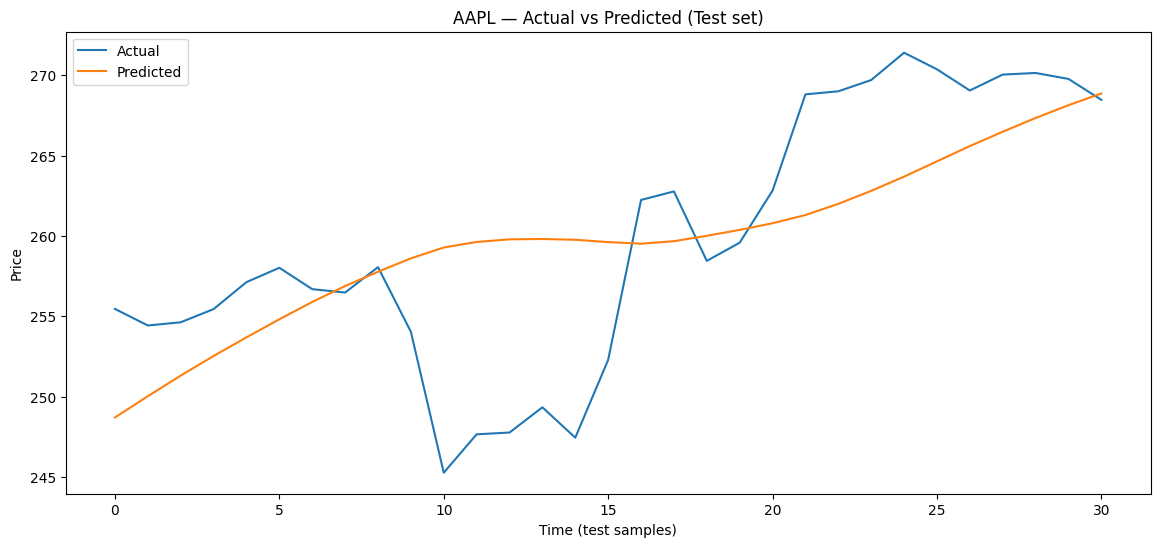

In [37]:
# Plot actual vs predicted (test region)
plt.figure(figsize=(14,6))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(pred, label='Predicted')
plt.title(f"{TICKER} — Actual vs Predicted (Test set)")
plt.xlabel("Time (test samples)")
plt.ylabel("Price")
plt.legend()
plt.show()


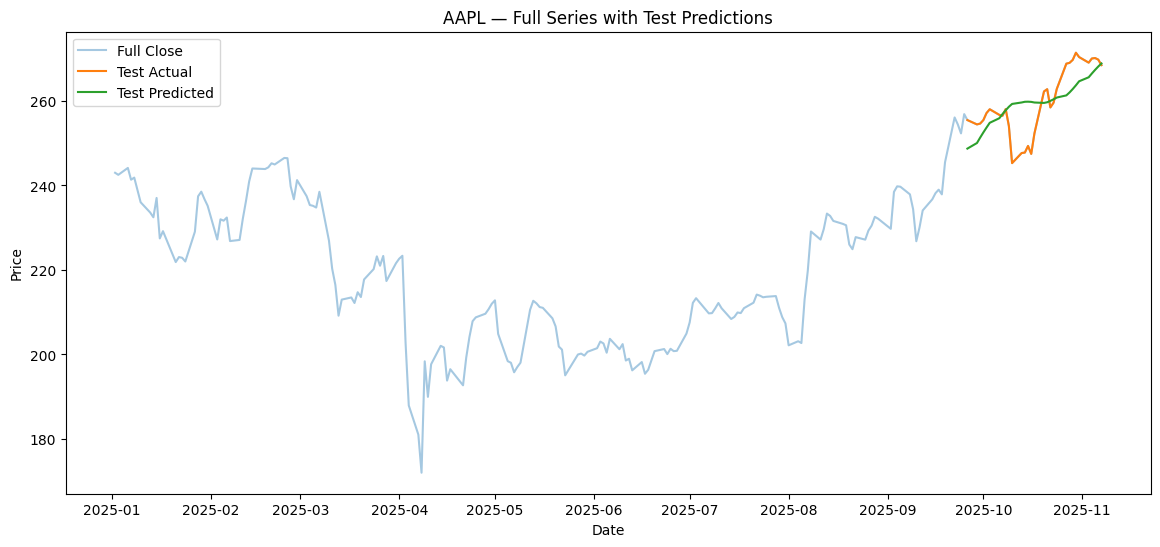

In [38]:
# Align dates for a nicer plot 
# Build DataFrame of predictions aligned to date index
test_start_idx = len(df) - len(y_test_unscaled)
dates = df.index[test_start_idx:]  # careful with offsets
pred_df = pd.DataFrame({'Actual': y_test_unscaled.flatten(), 'Predicted': pred.flatten()}, index=dates)

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Full Close', alpha=0.4)
plt.plot(pred_df['Actual'], label='Test Actual')
plt.plot(pred_df['Predicted'], label='Test Predicted')
plt.title(f"{TICKER} — Full Series with Test Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

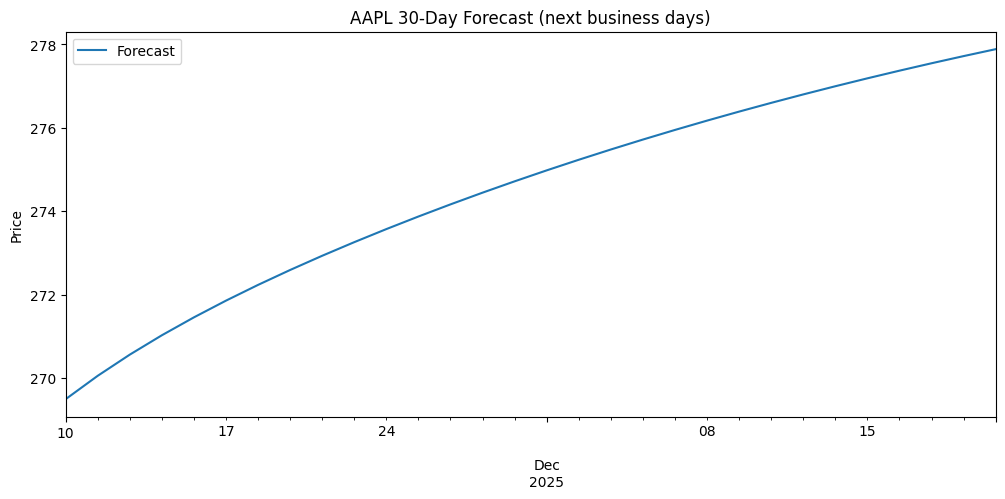

In [39]:
# Forecast next N days (using last SEQ_LENGTH days and iterative prediction)
def forecast_future(model, last_sequence, n_days, scaler):
    seq = last_sequence.copy()
    preds = []
    for _ in range(n_days):
        input_seq = seq.reshape(1, seq.shape[0], 1)
        pred_scaled = model.predict(input_seq)[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(-1,1))[0,0]
        preds.append(pred_unscaled)
        seq = np.concatenate([seq[1:], pred_scaled.reshape(1,1)], axis=0)
    return np.array(preds)

last_seq = prices_scaled[-SEQ_LENGTH:]   # most recent sequence
future_days = 30
future_preds = forecast_future(model, last_seq, future_days, scaler)

# Show forecast
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')  # business days
forecast_df = pd.DataFrame({'Forecast': future_preds}, index=future_dates)
forecast_df.plot(figsize=(12,5), title=f"{TICKER} {future_days}-Day Forecast (next business days)")
plt.ylabel("Price")
plt.show()
